<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [49]:
!python --version

Python 3.10.9


In [50]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Block Building

In [51]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

In [52]:
qgb = QGramsBlocking(qgrams=6)
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Q-Grams Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

In [53]:
qgb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.2431 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.32% 
	Recall:        99.91%
	F1-score:       0.63%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1075
	False positives: 337743
	True negatives: 820032
	False negatives: 1
	Total comparisons: 338818
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.3172794833804579,
 'Recall %': 99.90706319702602,
 'F1 %': 0.6325501479873138,
 'True Positives': 1075,
 'False Positives': 337743,
 'True Negatives': 820032,
 'False Negatives': 1}

# Block Cleaning

In [54]:
from pyjedai.block_cleaning import BlockFiltering

In [55]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

# Comparison Cleaning


In [56]:
from pyjedai.block_cleaning import BlockPurging

In [57]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/4932 [00:00<?, ?it/s]

In [58]:
cbbp.evaluate(cleaned_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 3224.0
Runtime: 0.0268 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.86% 
	Recall:        98.88%
	F1-score:       1.70%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1064
	False positives: 122748
	True negatives: 1035016
	False negatives: 12
	Total comparisons: 123812
──────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 0.8593674280360546,
 'Recall %': 98.88475836431226,
 'F1 %': 1.7039267183396323,
 'True Positives': 1064,
 'False Positives': 122748,
 'True Negatives': 1035016,
 'False Negatives': 12}

# Progressive Entity Matching

Applies Entity Matching to a subset of candidate pairs based on prioritization scheme.

In [88]:
from pyjedai.prioritization import (
    GlobalTopPM,
    LocalTopPM,
    EmbeddingsNNBPM,
    GlobalPSNM,
    LocalPSNM,
    RandomPM,
    PESM
)

In [89]:
%%time
ltpm = LocalTopPM(
    budget = 5000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

ltpm_pairs_graph = ltpm.predict(cleaned_blocks, data, tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 2.48 s, sys: 16.3 ms, total: 2.5 s
Wall time: 2.48 s


In [90]:
%%time
gtpm = GlobalTopPM(
    budget = 5000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gtpm_pairs_graph = gtpm.predict(cleaned_blocks, data, tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 1.27 s, sys: 4.14 ms, total: 1.27 s
Wall time: 1.26 s


In [91]:
%%time
gpsnm = GlobalPSNM(
    budget = 5000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gpsnm_pairs_graph = gpsnm.predict(cleaned_blocks, data, tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 323 ms, sys: 0 ns, total: 323 ms
Wall time: 322 ms


In [92]:
%%time
lpsnm = LocalPSNM(
    budget = 5000,
    pwScheme = 'ID',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

lpsnm_pairs_graph = lpsnm.predict(cleaned_blocks, data, tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 45.8 ms, sys: 45 µs, total: 45.9 ms
Wall time: 45.1 ms


In [93]:
%%time
ennbpm = EmbeddingsNNBPM(
    budget = 5000,
    vectorizer = 'sminilm',
    similarity_search = 'faiss',
    metric = 'dice',
    tokenizer = 'white_space_tokenizer',
    similarity_threshold = 0.1
)
ennbpm_pairs_graph = ennbpm.predict(cleaned_blocks, data, tqdm_disable=True, method='DFS', emit_all_tps_stop=False)

Embeddings-NN Block Building [sminilm, faiss]:   0%|          | 0/2152 [00:00<?, ?it/s]

Device selected:  cpu
Loading embeddings from file...
Loading file:  .embeddings/sminilm_d1_1.npy
Loading file:  .embeddings/sminilm_d2_2.npy
Loading embeddings from file finished
Saving embeddings...
CPU times: user 125 ms, sys: 11.4 ms, total: 137 ms
Wall time: 38.2 ms


In [94]:
%%time
rpm = RandomPM(
    budget = 5000,
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

rpm_pairs_graph = rpm.predict(cleaned_blocks, data, tqdm_disable=True)

CPU times: user 25.5 ms, sys: 4.04 ms, total: 29.5 ms
Wall time: 29 ms


In [99]:
%%time
pesm = PESM(
    budget = 5000,
    w_scheme = 'X2',
    metric='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

pesm_pairs_graph = pesm.predict(cleaned_blocks, data, tqdm_disable=True, method='HB', emit_all_tps_stop=True)

CPU times: user 5.31 s, sys: 15 µs, total: 5.31 s
Wall time: 5.31 s


In [104]:
matchers_data = []

matchers_data.append(("Random", rpm))
matchers_data.append(("Local Top", ltpm))
matchers_data.append(("Global Top", gtpm))
matchers_data.append(("GSN", gpsnm))
matchers_data.append(("ES", pesm))
matchers_data.append(("ENNBPM-DFS", ennbpm))

Random
Local Top
Global Top
GSN
ES
ENNBPM-DFS


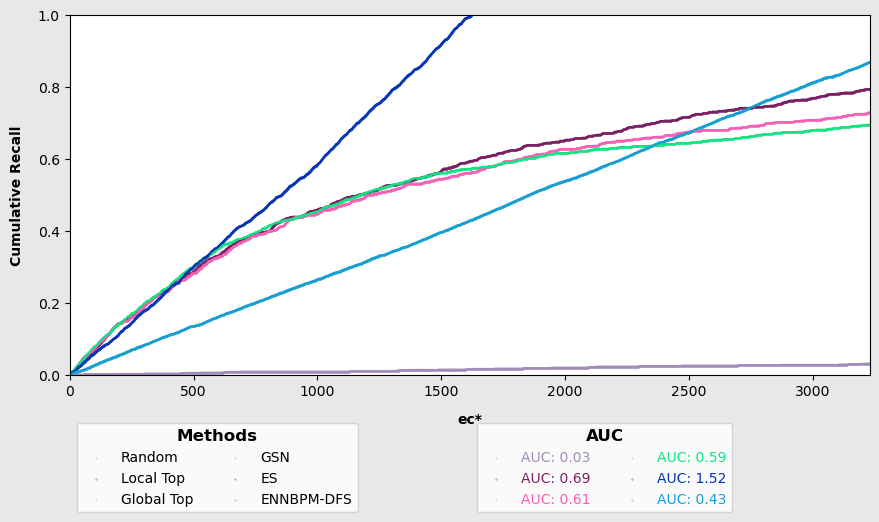

CPU times: user 523 ms, sys: 3.97 ms, total: 527 ms
Wall time: 526 ms


In [105]:
%%time
progressive_matchers_evaluator = Evaluation(data)
progressive_matchers_evaluator.evaluate_auc_roc(matchers_data = matchers_data, proportional = False)

# Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [ ]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph, data)

In [ ]:
ccc.evaluate(clusters, with_classification_report=True)

In [ ]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering
umc = UniqueMappingClustering()
clusters = umc.process(pairs_graph, data)

In [ ]:
umc.evaluate(clusters, with_classification_report=True)